# Feature Selection and Feature Engineering

We want to do our best to make good predictions by creating good models. One way we can improve our model is to consider the data's feature and either specifically _select_ features (**feature selection**) and/or _create new features_ (called **feature engineering**)

# Learning Objectives

- Use correlations and other algorithms to inform feature selection
- Address the problem of multicollinearity in regression problems
- Create new features for use in modeling
    - Use `PolynomialFeatures` to build compound features

In [1]:
# Initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection

New dataset for today! Insurance costs

My source: https://www.kaggle.com/mirichoi0218/insurance (they got the idea for cleaning up the original open source data from [Machine Learning with R](https://www.packtpub.com/product/machine-learning-with-r-third-edition/9781788295864))

Target: `charges`

In [2]:
# Read in the data
df = pd.read_csv('data/insurance.csv')

In [3]:
# explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


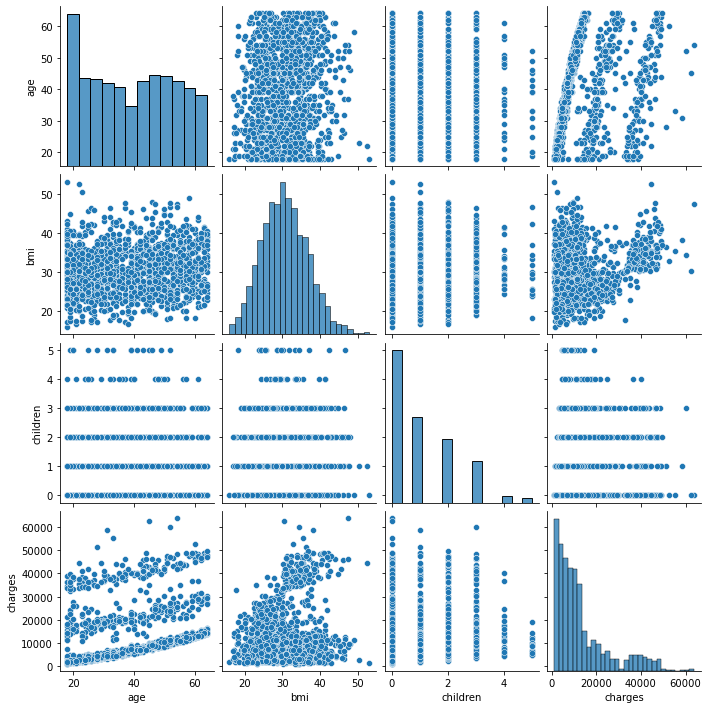

In [4]:
# visualize relationships between numeric columns
sns.pairplot(df);

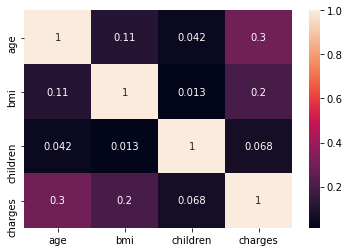

In [5]:
# visualize correlations between numeric columns
sns.heatmap(df.corr(), annot=True);

#### Observations?

- 


### First Things First - Train Test Split!

In [6]:
# Import train test split
from sklearn.model_selection import train_test_split

In [7]:
# Define our X and y
X = df.drop(columns = 'charges')
y = df.charges

In [9]:
# Train test split
# Use test_size=0.25, random_state=42
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = 0.25,
                                                random_state = 42)

### Need to Encode!

In [10]:
# Import our One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
# Going to use ColumnTransformer to encode only cat cols
from sklearn.compose import ColumnTransformer

In [11]:
# Which columns are categoricals?
# Handy trick!

cat_cols = [c for c in df.columns if df[c].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

In [13]:
# example of pulling out just objects
df.describe(include = ['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [82]:
X_train

,age,sex,bmi,children,smoker,region
693,24,male,23.655,0,no,northwest
1297,28,female,26.510,2,no,southeast
634,51,male,39.700,1,no,southwest
1022,47,male,36.080,1,yes,southeast
178,46,female,28.900,2,no,southwest
...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast
1130,39,female,23.870,5,no,southeast
1294,58,male,25.175,0,no,northeast
860,37,female,47.600,2,yes,southwest


In [91]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [90]:
cat_cols = ['sex', 'smoker', 'region']

In [84]:
cat_cols

['sex', 'smoker', 'region']

In [92]:
X_train_enc

array([[ 1.   ,  0.   ,  1.   , ..., 24.   , 23.655,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 28.   , 26.51 ,  2.   ],
       [ 1.   ,  0.   ,  0.   , ..., 51.   , 39.7  ,  1.   ],
       ...,
       [ 1.   ,  0.   ,  0.   , ..., 58.   , 25.175,  0.   ],
       [ 0.   ,  1.   ,  0.   , ..., 37.   , 47.6  ,  2.   ],
       [ 1.   ,  0.   ,  0.   , ..., 55.   , 29.9  ,  0.   ]])

In [76]:
X_train.head()

,age,sex,bmi,children,smoker,region
693,24,male,23.655,0,no,northwest
1297,28,female,26.510,2,no,southeast
634,51,male,39.700,1,no,southwest
1022,47,male,36.080,1,yes,southeast
178,46,female,28.900,2,no,southwest


In [86]:
pd.DataFrame(X_train_enc, columns = ct.get_feature_names()).head()

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,1.0,0.0,1.0,0.0,0.0,24.0,23.655,0.0
1,0.0,0.0,0.0,1.0,0.0,28.0,26.510,2.0
2,1.0,0.0,0.0,0.0,1.0,51.0,39.700,1.0
3,1.0,1.0,0.0,1.0,0.0,47.0,36.080,1.0
4,0.0,0.0,0.0,0.0,1.0,46.0,28.900,2.0


### Now To Scale!

In [26]:
# Import our scaler
from sklearn.preprocessing import StandardScaler

# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [28]:
pd.DataFrame(X_train_scaled, columns= ct.get_feature_names()).head()

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500
1,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605
2,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947
3,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947
4,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605


### And let's model!

In [30]:
# Import our linear regression function
from sklearn.linear_model import LinearRegression

# instantiate
lr = LinearRegression()

# fit
lr.fit(X_train_scaled,y_train)

# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [31]:
# evaluate
from sklearn.metrics import r2_score

r2_score(y_train,train_preds)

0.7449555328228536

In [32]:
r2_score(y_test,test_preds)

0.7672642952734355

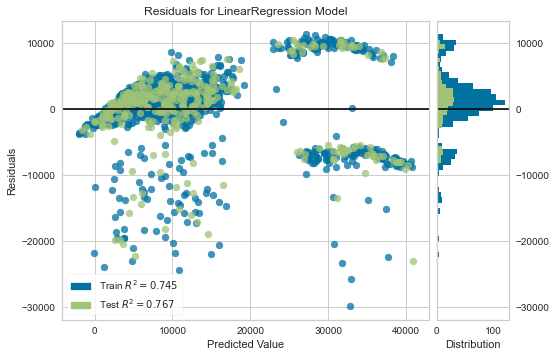

In [33]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

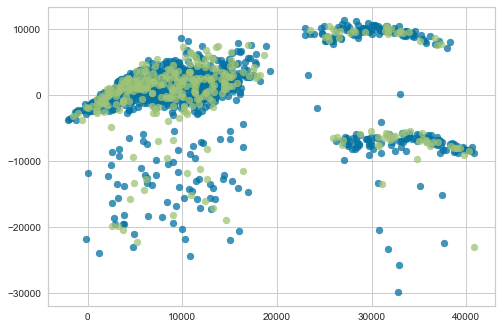

In [38]:
plt.scatter(train_preds,(train_preds-y_train),alpha = 0.75)
plt.scatter(test_preds,(test_preds-y_test),alpha = 0.75)

Ideas to continue improving this model?

- 


## Feature Importance through Coefficients

Because we've scaled our data, we can explore our coefficients to see which are having more of an impact on our model.

Note! This, or using p-values from a statsmodels model, is all you're expected to do in this project!

In [39]:
# Let's make our scaled training data a df, for ease of use
X_train_scaled = pd.DataFrame(X_train_scaled, columns=ct.get_feature_names())
X_train_scaled.head()

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500
1,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605
2,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947
3,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947
4,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605


In [40]:
# Same with X_test_scaled
X_test_scaled = pd.DataFrame(X_test_scaled, columns=ct.get_feature_names())

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
# Check the coefficients
lr.coef_

array([  22.81029539, 9546.25195286, -152.80047116, -341.97255581,
       -370.63084494, 3643.06598197, 2042.26503648,  513.51689408])

In [42]:
# look at the coefficients with the names of each col
dict(zip(X_train_scaled.columns,lr.coef_))

{'ohe__x0_male': 22.81029539203953,
 'ohe__x1_yes': 9546.251952862465,
 'ohe__x2_northwest': -152.80047115644084,
 'ohe__x2_southeast': -341.97255581488207,
 'ohe__x2_southwest': -370.6308449356984,
 'age': 3643.065981965231,
 'bmi': 2042.2650364763717,
 'children': 513.5168940844073}

<AxesSubplot:>

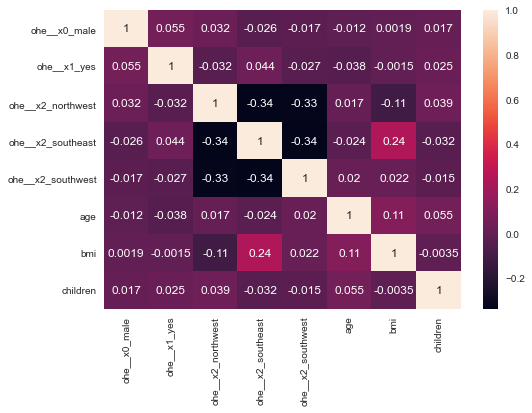

In [44]:
sns.heatmap(X_train_scaled.corr(),annot=True)

In [53]:
# Let's model again using only the 3 strongest coefficients
# instantiate
lr_subset = LinearRegression()

used_cols = ['ohe__x1_yes','ohe__x2_southeast','bmi']

lr_subset.fit(X_train_scaled[used_cols], y_train)

LinearRegression()

In [56]:
lr_subset.score(X_train_scaled[used_cols], y_train)

0.6511592160038188

In [54]:
lr_subset.score(X_test_scaled[used_cols], y_test)

0.6814485564015329

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


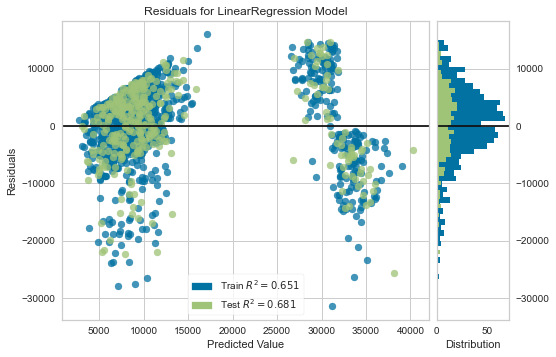

In [55]:
# visualizing our residuals
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

visualizer = ResidualsPlot(lr_subset)

visualizer.fit(X_train_scaled[used_cols], y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled[used_cols], y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

#### Evaluate

- 


## Interaction Terms

When do we need interaction terms? And how do we check for them?

Well, first things first - what interactions do _you_ think would make sense? That's the easiest way to incorporate interaction terms - use domain knowledge to think through what usefully could be combined into an interaction.

As for how to check if something might be better captured as an interaction...

In [57]:
# add the target back onto our OHE df
# note the index difference...
train_df = X_train_scaled.copy()
train_df['target'] = y_train.reset_index(drop=True)
train_df

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children,target
0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500,2352.96845
1,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605,4340.44090
2,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947,9391.34600
3,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947,42211.13820
4,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605,8823.27900
...,...,...,...,...,...,...,...,...,...
998,-1.009014,-0.508399,-0.570059,-0.590015,-0.571594,-1.514757,0.139468,2.404710,4561.18850
999,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.018189,-1.105101,3.235263,8582.30230
1000,0.991067,-0.508399,-0.570059,-0.590015,-0.571594,1.335848,-0.887967,-0.917500,11931.12525
1001,-1.009014,1.966960,-0.570059,-0.590015,1.749494,-0.160720,2.843247,0.743605,46113.51100


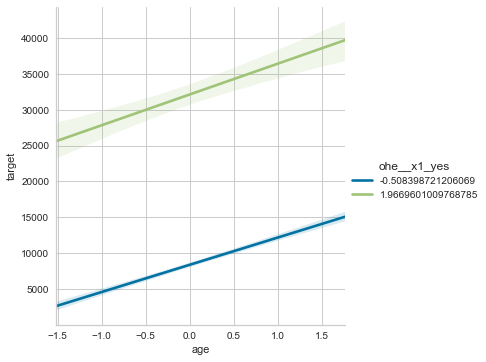

In [58]:
# an example of no interaction term...
sns.lmplot(x='age', y='target', hue='ohe__x1_yes', data=train_df, scatter=False)
plt.show()

How do I know these two variables, `age` and `smoker_yes`, aren't interacting? 

- Look at the slopes - parallel


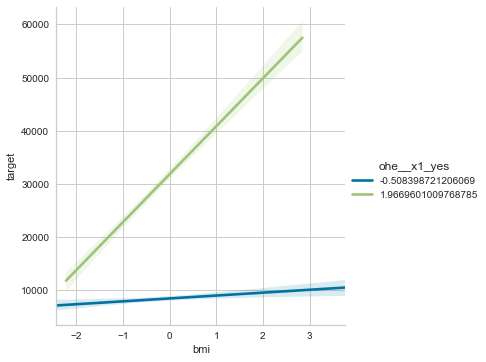

In [59]:
# now let's look at something else...
sns.lmplot(x='bmi', y='target', hue='ohe__x1_yes', data=train_df, scatter=False)
plt.show()

What do you think?

- 


## Polynomial Features

Instead of just multiplying features at random, we might consider trying **every possible product of features**. That's what PolynomialFeatures does.


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Demonstrating this on a toy example, with a single x variable predicting y.

In [60]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

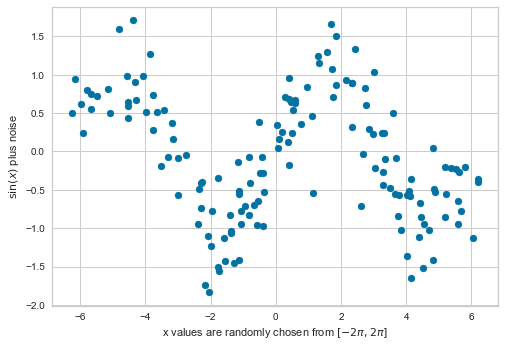

In [61]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$ plus noise')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()

In [62]:
# Fitting a linear model
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression()

In [63]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [64]:
# Scoring our model
lr.score(x.reshape(-1, 1), y)

0.07740318355694431

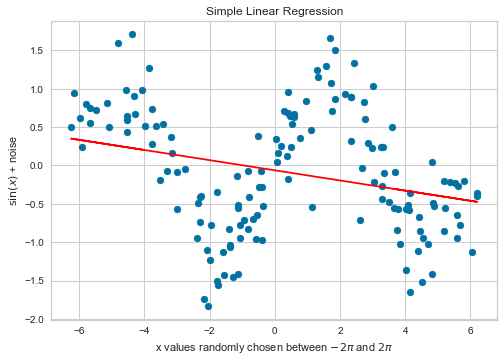

In [65]:
# Visualize it
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Simple Linear Regression")

plt.show()

Is this a good model? Well - of course not. It's definitely **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [66]:
# Import polynomial features
from sklearn.preprocessing import PolynomialFeatures

In [67]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [-0.0867]
R-Squared: -0.000


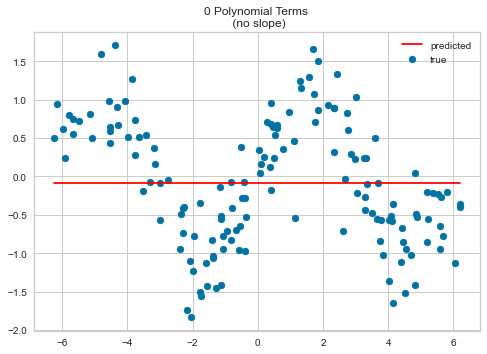

-------------
Coefficients:  [-0.0642 -0.0662]
R-Squared: 0.077


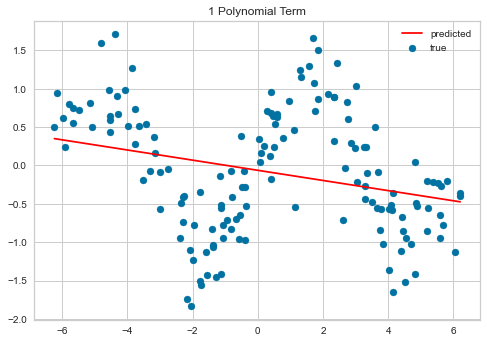

-------------
Coefficients:  [-0.1161 -0.0678  0.0045]
R-Squared: 0.081


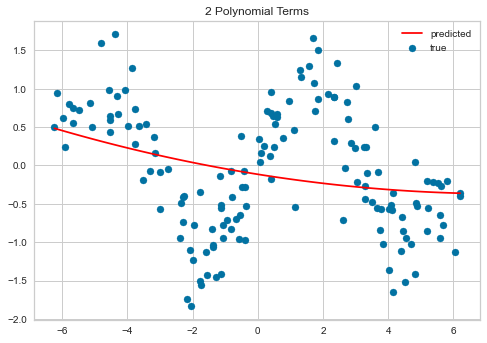

-------------
Coefficients:  [-0.1077  0.1454  0.0042 -0.0095]
R-Squared: 0.257


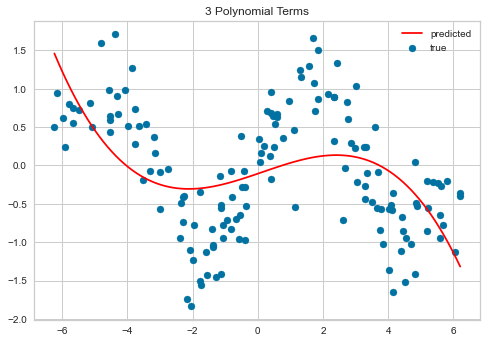

-------------
Coefficients:  [-0.0445  0.6422  0.0022 -0.0693  0.0001  0.0014]
R-Squared: 0.632


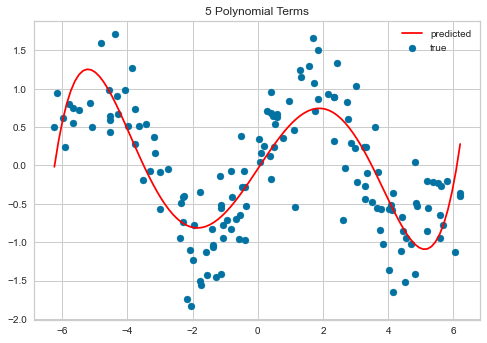

-------------
Coefficients:  [ 0.0257  0.986  -0.0135 -0.1501  0.0012  0.006  -0.     -0.0001]
R-Squared: 0.745


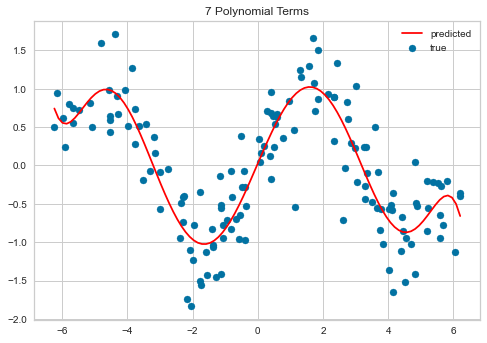

-------------
Coefficients:  [ 0.0335  0.9978 -0.0204 -0.1547  0.0022  0.0065 -0.0001 -0.0001  0.
  0.    ]
R-Squared: 0.745


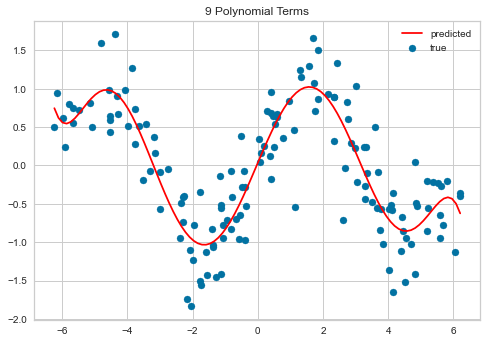

-------------
Coefficients:  [ 0.095   0.8893 -0.1569 -0.1025  0.0453 -0.0003 -0.005   0.0002  0.0003
  0.     -0.     -0.      0.      0.    ]
R-Squared: 0.755


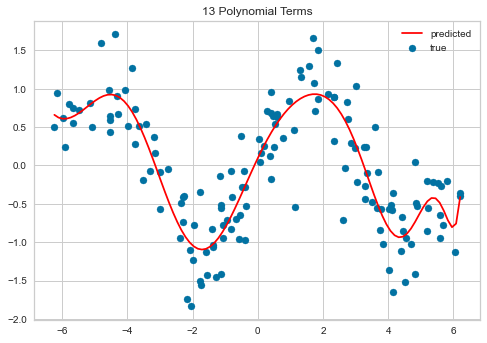

-------------
Coefficients:  [ 0.0812  0.7404 -0.1146  0.0878  0.0301 -0.0674 -0.0034  0.0107  0.0003
 -0.0009 -0.      0.      0.     -0.     -0.      0.      0.     -0.
 -0.    ]
R-Squared: 0.758


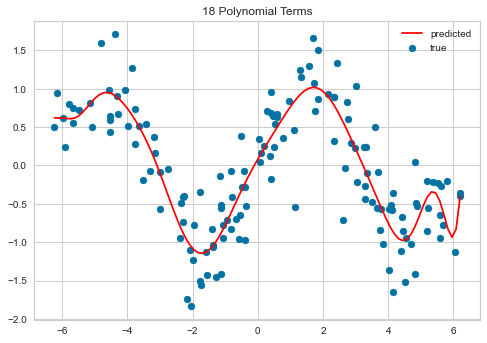

In [68]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

Evaluate: which of these is the best?

- I'd go with 7-polynomial


Evaluate: so what?

- 


### Now on our dataset

In [ ]:
# First all polynomial terms

In [70]:
poly = PolynomialFeatures(degree = 3)

In [71]:
poly.fit(X_train_scaled)

PolynomialFeatures(degree=3)

In [72]:
X_train_deg3 = poly.transform(X_train_scaled)

In [74]:
pd.DataFrame(X_train_deg3,columns = poly.get_feature_names())

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x5^3,x5^2 x6,x5^2 x7,x5 x6^2,x5 x6 x7,x5 x7^2,x6^3,x6^2 x7,x6 x7^2,x7^3
0,1.0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500,0.982213,...,-1.284956,-1.348435,-1.084421,-1.415050,-1.137994,-0.915183,-1.484956,-1.194213,-0.960395,-0.772356
1,1.0,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605,1.018109,...,-0.516054,-0.428385,0.478416,-0.355610,0.397141,-0.443524,-0.295197,0.329674,-0.368176,0.411176
2,1.0,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947,0.982213,...,0.586360,1.071007,-0.060911,1.956229,-0.111257,0.006328,3.573118,-0.203214,0.011557,-0.000657
3,1.0,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947,0.982213,...,0.168134,0.282231,-0.026487,0.473755,-0.044461,0.004173,0.795248,-0.074632,0.007004,-0.000657
4,1.0,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605,1.018109,...,0.111053,-0.061960,0.171803,0.034569,-0.095854,0.265784,-0.019287,0.053480,-0.148289,0.411176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,1.0,-1.009014,-0.508399,-0.570059,-0.590015,-0.571594,-1.514757,0.139468,2.404710,1.018109,...,-3.475596,0.320009,5.517584,-0.029464,-0.508021,-8.759284,0.002713,0.046775,0.806494,13.905553
999,1.0,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.018189,-1.105101,3.235263,1.018109,...,-0.000006,-0.000366,0.001070,-0.022214,0.065032,-0.190386,-1.349604,3.951062,-11.567014,33.863251
1000,1.0,0.991067,-0.508399,-0.570059,-0.590015,-0.571594,1.335848,-0.887967,-0.917500,0.982213,...,2.383810,-1.584570,-1.637270,1.053298,1.088329,1.124525,-0.700150,-0.723436,-0.747496,-0.772356
1001,1.0,-1.009014,1.966960,-0.570059,-0.590015,1.749494,-0.160720,2.843247,0.743605,1.018109,...,-0.004152,0.073443,0.019208,-1.299266,-0.339802,-0.088870,22.984953,6.011344,1.572170,0.411176


In [ ]:
# Interaction terms with Polynomial Features


Evaluate: What do you think? Is this blanket way of approaching polynomial or interaction terms useful?

- probably not. not without using RFE recursive feature elimination


## Feature Selection and Feature Importances...

Not much time to do this, but:

- Lasso Regression (L1 regularization)
- Recursive Feature Elimination
- Forward Stepwise Selection

Can always check out the python library [`eli5`](https://eli5.readthedocs.io/en/latest/index.html) (yes, Explain Like I'm 5)

## Resources:

[Feature Engineering and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) (computing done in R, but book focuses mostly on discussing the hows and whys rather than focusing on implementation)

- Their chapter on [Encoding Categorical Predictors](https://bookdown.org/max/FES/encoding-categorical-predictors.html)
- And their chapter on [Detecting Interaction Effects](https://bookdown.org/max/FES/detecting-interaction-effects.html)